In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump,load
import os

def download_data(tickers,start,end):
    data=yf.download(tickers,start=start,end=end)
    data=data.stack().reset_index()
    data.drop(columns=["Close","Open","High","Low","Volume"],inplace=True)
    data.rename(columns={"level_1":"ticker","Date":"date","Adj Close":"close"},inplace=True)
    return data

def preprocess_data(df):
    df["return"]=df.groupby("ticker")["close"].pct_change()
    df["date"]=pd.to_datetime(df["date"])
    return df

#kelly fractions calculated daily using 2y rolling window

#uses closed form approximation of fractions from Positional Options Trading book
def noncorrelated_kelly(df,window=504):
    df["kelly_fraction"] = df.groupby("ticker")["return"].transform(
        lambda x: x.shift(1).rolling(window=window).apply(calculate_kelly_fraction,raw=False))
    df = df.groupby('date').apply(normalize_fractions)
    return df

def calculate_kelly_fraction(x):
    mean = x.mean()
    std = x.std()
    if std > 0:
        skew = ((x - mean)**3).mean() / std**3
    else:
        skew = pd.NA

    fraction = (mean / (mean**2 + std**2)) + ((skew*(mean**2)) / (mean**2 + std**2)**3)
    return fraction

def normalize_fractions(group):
    df["kelly_fraction"] = df["kelly_fraction"].fillna(0)
    group["kelly_fraction"]=group["kelly_fraction"].clip(lower=0)
    total_fraction = group["kelly_fraction"].sum()
    if total_fraction>1:
        group["kelly_fraction"] = group["kelly_fraction"] / total_fraction
    return group

#applies optimization from Frontiers paper https://www.frontiersin.org/articles/10.3389/fams.2020.577050/full
def correlated_kelly(df, start_year, window=252, use_total_balance=True):
    
    date_count = len(df["date"].unique())
    stock_dim = len(df["ticker"].unique())
    df['kelly_fraction']=0
    
    if use_total_balance:
        #sum of all fractions == 1
        constraints = [{'type': 'eq', 'fun': lambda F: np.sum(F)-1}]
    else:
        #sum of all fractions <=1
        constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
        
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([1/stock_dim]*stock_dim)
    
    rf_rate = .01/252

    for d in range(1,date_count-window):
        
        start_idx = d*stock_dim
        end_idx = (d+window)*stock_dim
        temp = df.iloc[start_idx:end_idx]
        temp = temp.pivot(index="date",columns="ticker",values="return")
        
        cov = temp.cov().values
        mean = temp.mean().values
        inv_cov = np.linalg.inv(cov)
        r = np.array([rf_rate]*stock_dim)
    
        def objective(F):
            return -(rf_rate + F.T@(mean-r)-((1/2)*F.T@inv_cov@F))
    
        result = minimize(objective,F_initial,method="SLSQP",
                        bounds=bounds, constraints=constraints)
    
        if result["success"] == True:
            F=result["x"]
        else:
            print(f"Optimization could not be solved between indices {left_index},{right_index}")
            break
    
        #.loc is inclusive of right index, therefore subtract 1
        df.loc[end_idx:end_idx+stock_dim-1, 'kelly_fraction'] = F

        if end_idx%(stock_dim*252)==0:
            print("calculated up to: ",df["date"].iloc[end_idx])
    return df

def forecasted_correlated_kelly(df, start_year, lag, window=252, use_total_balance=True):
    
    date_count = len(df["date"].unique())
    stock_dim = len(df["ticker"].unique())
    df['kelly_fraction']=0
    
    if use_total_balance:
        #sum of all fractions == 1
        constraints = [{'type': 'eq', 'fun': lambda F: np.sum(F)-1}]
    else:
        #sum of all fractions <=1
        constraints = [{'type': 'ineq', 'fun': lambda F: 1-np.sum(F)}]
        
    bounds = [(0,1) for _ in range(stock_dim)]
    F_initial = np.array([1/stock_dim]*stock_dim)
    
    rf_rate = .01/252

    lagged_cov_matrices = []
    predicted_cholesky = []
    sse_cholesky_list = []
    dates = []
    
    for d in range(1,date_count-window):
        
        start_idx = d*stock_dim
        end_idx = (d+window)*stock_dim

        year = df.loc[end_idx,"date"].year

        temp = df.iloc[start_idx:end_idx]
        temp = temp.pivot(index="date",columns="ticker",values="return")
        hist_cov_matrix = temp.cov().values
        lagged_cov_matrices.append(hist_cov_matrix)
        
        if len(lagged_cov_matrices) > lag:
            del lagged_cov_matrices[0]

        if year <= start_year or len(lagged_cov_matrices)<lag:
            continue
        else:
            mean = temp.mean().values
            r = np.array([rf_rate]*stock_dim)
            
            pred_cov_matrix = forecast_cov_matrix(lagged_cov_matrices,predicted_cholesky,year,lag)
            inv_pred_cov_matrix = np.linalg.inv(pred_cov_matrix)

            start_idx2 = start_idx + stock_dim
            end_idx2 = end_idx + stock_dim
            temp2 = df.iloc[start_idx2:end_idx2]
            temp2 = temp2.pivot(index="date",columns="ticker",values="return")
            actual_col_matrix = temp2.cov().values
            rows, cols = np.tril_indices(actual_col_matrix.shape[0])
            cholesky_factor = np.linalg.cholesky(actual_col_matrix)
            entry_row = cholesky_factor[rows, cols]
            sse_cholesky = ((predicted_cholesky[-1] - entry_row)**2).sum()
            sse_cholesky_list.append(sse_cholesky)
            dates.append(df.loc[end_idx2-1,"date"])

        
            def objective(F):
                return -(rf_rate + F.T@(mean-r)-((1/2)*F.T@inv_pred_cov_matrix@F))
        
            result = minimize(objective,F_initial,method="SLSQP",
                            bounds=bounds, constraints=constraints)
        
            if result["success"] == True:
                F=result["x"]
            else:
                print(f"Optimization could not be solved between indices {left_index},{right_index}")
                break
        
            #.loc is inclusive of right index, therefore subtract 1
            df.loc[end_idx:end_idx+stock_dim-1, 'kelly_fraction'] = F
    
            if end_idx%(stock_dim*252)==0:
                print("calculated up to: ",df["date"].iloc[end_idx])

    error_df = pd.DataFrame(sse_cholesky_list, index=dates, columns=['sse_cholesky'])
    error_df.to_csv("sse_cholesky.csv")
    
    return df


def forecast_cov_matrix(matrix_list, pred_cholesky_list, year, lag):

    if len(matrix_list) < 1:
        print("No matrices avaiable to forecast with")
    else:
        matrix_dim = matrix_list[0].shape[0]
        rows, cols = np.tril_indices(matrix_dim)
        
        entry_matrix = []
        for cov_matrix in matrix_list:
            cholesky_factor = np.linalg.cholesky(cov_matrix)
            entry_row = cholesky_factor[rows, cols]
            entry_matrix.append(entry_row)
        entry_df = pd.DataFrame(entry_matrix)
    
        pred_entry_row = []
        path = fr"hist_cf_entry_svr_models_lag_{lag}\\{year}"
        for col in entry_df.columns:
            model_path = path + fr"\svr_model_entry_{col}.joblib"
            loaded_model = load(model_path)
            pred = loaded_model.predict(entry_df[col].values.reshape(1, -1))
            pred_entry_row.append(pred[0])

        pred_matrix = np.zeros((matrix_dim, matrix_dim))
        pred_matrix[rows, cols] = np.array(pred_entry_row)
        pred_cholesky_list.append(np.array(pred_entry_row))

        return pred_matrix

def daily_return(group):
    a=(group["return"] * group["kelly_fraction"]).sum()
    return a

def backtest_kelly(df, tick_dict, initial=1000000):
    port_returns = df.groupby("date").apply(daily_return).reset_index(name="port_return")
    trade_df = pd.DataFrame()
    trade_df["date"] = port_returns["date"]
    trade_df["port_return"] = port_returns["port_return"]
    trade_df["port_value"] = initial * ((1+trade_df["port_return"]).cumprod())
    
    return trade_df

def portfolio_performance(df,return_col,value_col,rfr="^TNX",interval=252):
    start_date = df["date"].iloc[0]
    end_date = df["date"].iloc[-1]

    years = (start_date-end_date).days / interval
    
    mean_return = df[return_col].mean()
    std_return = df[return_col].std()
    start_value = df[value_col].iloc[0]
    end_value = df[value_col].iloc[-1]
    total_return = (end_value - start_value)/end_value
    annualized_return = ((1+total_return)**(1/years)) - 1
    sharpe, annualized_sharpe = calculate_sharpe(df,return_col,rfr,interval) 
    max_drawdown = df[return_col].min()

    print(f"mean return: {mean_return}")
    print(f"std return: {std_return}")
    print(f"max drawdown: {max_drawdown}")
    print(f"total return: {total_return}")
    print(f"annualized return: {annualized_return}")
    print(f"sharpe: {sharpe}")
    print(f"annualized sharpe: {annualized_sharpe}")


def calculate_sharpe(df,return_col,rfr='^TNX',interval=252):
    start_date = df["date"].iloc[0]
    end_date = df["date"].iloc[-1]
    
    data = yf.download(rfr, start=start_date, end=end_date)
    data=data.reset_index()
    rate_df = pd.DataFrame()
    rate_df[["date","rate"]] = data[["Date","Adj Close"]]
    port_df = pd.DataFrame()
    port_df[["date","return"]] = df[["date",return_col]] 
    temp_df = pd.merge(port_df,rate_df,on="date",how="outer")
    temp_df["rate"]=temp_df["rate"].fillna(method="ffill")
    temp_df["rate"] = (temp_df["rate"]/interval)/100

    sharpe = ((temp_df["return"]-(.01/252)).mean()) / temp_df["return"].std()
    annualized_sharpe = sharpe * np.sqrt(interval)

    return sharpe,annualized_sharpe

def plot_performance(df):
    plt.plot(df['date'], df['port_value'])
    plt.title('Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Value ($millions)')
    plt.show()

    cum_return1 = (df["port_return"]).cumsum()
    cum_return2 = (1+df["port_return"]).cumprod()

    fig, axs = plt.subplots(1,2,figsize=(12,5))

    axs[0].plot(df['date'], cum_return1)
    axs[0].set_title('Portfolio Cumulative Return (CumSum)')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Return')
    
    axs[1].plot(df['date'], cum_return2)
    axs[1].set_title('Portfolio Cumulative Return (CumProd)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Return')
    
    plt.tight_layout()
    plt.show()


In [40]:
def create_autoregressive_data_df(series, lag):
    column_names = [f"t-{lag-i}" for i in range(0,lag)] + ["t"]
    data_df = pd.DataFrame(columns = column_names)
    for i in range(lag,len(series)):
        window_array = np.array(series[i-lag:i+1]).reshape(1,-1)
        window_df = pd.DataFrame(window_array,columns=data_df.columns)
        data_df = pd.concat([data_df,window_df])
    data_df.index = series[lag:].index

    return data_df

def save_entry_data(df, entry, year,lag):
    path = os.path.join(f"hist_cf_entry_ar_data_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)

    csv_path = os.path.join(path, f"cholesky_factor_entry_{entry}.csv")
    df.to_csv(csv_path)
    
def get_best_svr_model(results_df, X_train, X_test, y_train, y_test):
    
    best_params_df = results_df[results_df['mean_test_score'] == results_df['mean_test_score'].max()].reset_index(drop=True)
    test_mse_list = []
    best_params_list = list(best_params_df["params"])
    
    for params in best_params_list:
        temp_model = SVR(**params)
        temp_model.fit(X_train,y_train)
        y_pred = temp_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        test_mse_list.append(test_mse)
        
    best_idx = test_mse_list.index(min(test_mse_list))
    best_params = best_params_list[best_idx]
    best_model = SVR(**best_params)
    
    return best_model

def save_svr_gridsearch_results(df,year,entry,lag):

    path = os.path.join(f"hist_cf_entry_svr_gridsearch_results_lag_{lag}",
                       f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
        
    csv_path = os.path.join(path, f"svr_gridsearch_results_entry_{entry}.csv")
    df.to_csv(csv_path)

def save_svr_model(model, year, entry, lag):

    path = os.path.join(f"hist_cf_entry_svr_models_lag_{lag}",
                        f"{year}")

    if not os.path.exists(path):
        os.makedirs(path,exist_ok=True)
                              
    model_path = os.path.join(path,f"svr_model_entry_{entry}.joblib")
    
    dump(model, model_path)


class HistoricalCholesky:

    
    def __init__(self, df=None, cov_window=252, autoregressive_lag=1, retraining_interval="y"):
        
        self.stock_df = df
        self.cov_window = cov_window
        self.autoregressive_lag = autoregressive_lag
        self.models_downloaded = False
        #do not do following lines on initialization
        self.total_hist_cholesky_df = self.get_historical_cholesky(self.stock_df)
        if retraining_interval == "y":
            self.hist_cholesky_data = self.yearly_data_split(self.total_hist_cholesky_df)

        self.cf_entry_autoregressive_data = self.get_cf_entry_autoregressive_data()
        self.model_dict = self.generate_svr_models()
        
        
    
    def get_historical_cholesky(self, df=None):
        
        date_count = len(df["date"].unique())
        stock_dim = len(df["ticker"].unique())
        entries_df = pd.DataFrame()
        for d in range(1,date_count-self.cov_window+1):
            start_idx = d*stock_dim
            end_idx = (d+self.cov_window)*stock_dim
            temp = df.iloc[start_idx:end_idx]
            temp = temp.pivot(index="date",columns="ticker",values="return")
            cov = temp.cov().values
            cholesky_factor = np.linalg.cholesky(cov).T
            entries = []
            for i in range(stock_dim):
                for j in range(i+1):
                    entries.append(cholesky_factor[j,i])
            row = np.array(entries).reshape(1, -1)
            row_df = pd.DataFrame(row)
            row_df["date"] = pd.to_datetime(temp.index[-1])
            row_df.set_index("date",inplace=True)
            entries_df = pd.concat([entries_df,row_df],axis=0)
        
        return entries_df

    
    def yearly_data_split(self, df):

        #check if df type is actually DataFrame if not return error
        data_dict = {}
        year_keys = list(df.index.year.unique())
        for year in year_keys:
            data_dict[year] = df[df.index.year <= year]
            
        return data_dict


    def get_cf_entry_autoregressive_data(self):
        years = list(self.hist_cholesky_data.keys())
        data_dict = {}
        for year in years:
            print(f"producing autoregressive data for entries in year: {year}")
            entry_list = list(self.hist_cholesky_data[year].columns)
            entry_data_list = []
            for entry in entry_list:
                print(f"producing autoregressive data for entry: {entry}, year: {year}")
                entry_data = create_autoregressive_data_df(series = self.hist_cholesky_data[year][entry],
                                                          lag = self.autoregressive_lag)
                entry_data_list.append(entry_data)
                save_entry_data(entry_data,entry,year,self.autoregressive_lag)

            data_sub_dict = dict(zip(entry_list, entry_data_list))

            data_dict[year] = data_sub_dict
        return data_dict
    
    
    def generate_svr_models(self):
    
        model_dict = {}
        for year, cf_entry_dict in self.cf_entry_autoregressive_data.items():
            print(f"generating models for entries in year: {year}")
    
            sub_dict = {}
            for entry, entry_data in cf_entry_dict.items():
                print(f"generating models for entry: {entry}, year: {year}")
                tscv = TimeSeriesSplit(n_splits=5)
                
                #expansion of paramter grid used in https://link.springer.com/article/10.1007/s10489-021-02217-5
                gridsearch_params = {
                    'C': [2**i for i in range(-10,11)],  # Example values, adjust based on your needs
                    'epsilon': [2**i for i in range(-10,11)]  # Example values
                }
                #gaussian kernel used
                gridsearch = GridSearchCV(SVR(kernel = "rbf"),gridsearch_params,cv=tscv,scoring='neg_mean_squared_error')
            
                X = entry_data[[f"t-{i}" for i in range(self.lag,0,-1)]]
                y = entry_data["t"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
                
                gridsearch.fit(X_train,y_train)
                results = pd.DataFrame(gridsearch.cv_results_)
                save_svr_gridsearch_results(results, year, entry, self.lag)
                
                final_model = get_best_svr_model(results, X_train, X_test, y_train, y_test)
                final_model.fit(X,y)
                save_svr_model(final_model, year, entry, self.lag)
                sub_dict[entry]=final_model
            #models trained over year-t,...,year will be use for forecasting in year+1
            model_dict[year+1]=sub_dict
        return model_dict
            


    
        

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#tickers in DJIA on Oct-31-2004, excludes tickers that became inactive

tickers = ['WMT', 'INTC', 'MSFT', 'KO', 'PG', 'AXP', 'IBM', 'MCD', 'JNJ', 'DIS', 'CAT', 'HD', 'MRK', 'MMM', 'BA', 'VZ', 'JPM', 'HON', 'T', 'HPQ', 'RTX', 'PFE', 'GE', 'AIG', 'MO', 'C', 'XOM']
start = '2005-01-01'
end = '2023-12-31'
initial_balance = 1000000

In [6]:
 df = download_data(tickers,start,end)

[*********************100%%**********************]  27 of 27 completed


In [7]:
df1=preprocess_data(df)

In [9]:
kelly_1 = correlated_kelly(df1,start_year=2007,window=252,use_total_balance=False)

calculated up to:  2007-01-04 00:00:00
calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [15]:
kelly_2 = correlated_kelly(df1,start_year=2007,window=252,use_total_balance=True)

calculated up to:  2007-01-04 00:00:00
calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [37]:
kelly_3 = forecasted_correlated_kelly(df1,2007,15,window=252,use_total_balance=True)

calculated up to:  2008-01-04 00:00:00
calculated up to:  2009-01-05 00:00:00
calculated up to:  2010-01-05 00:00:00
calculated up to:  2011-01-04 00:00:00
calculated up to:  2012-01-04 00:00:00
calculated up to:  2013-01-07 00:00:00
calculated up to:  2014-01-07 00:00:00
calculated up to:  2015-01-07 00:00:00
calculated up to:  2016-01-07 00:00:00
calculated up to:  2017-01-06 00:00:00
calculated up to:  2018-01-08 00:00:00
calculated up to:  2019-01-09 00:00:00
calculated up to:  2020-01-09 00:00:00
calculated up to:  2021-01-08 00:00:00
calculated up to:  2022-01-07 00:00:00
calculated up to:  2023-01-10 00:00:00


In [21]:
kelly_3 = pd.read_csv('forecasted_kelly_fractions_df.csv')

In [25]:
kelly_3["date"]=pd.to_datetime(kelly_3["date"])
kelly_3.set_index("date",inplace=True)

In [10]:
trade_1 = backtest_kelly(kelly_1,tickers,initial_balance)

In [27]:
trade_2 = backtest_kelly(kelly_2,tickers,initial_balance)

In [28]:
trade_3 = backtest_kelly(kelly_3,tickers,initial_balance)

In [11]:
portfolio_performance(trade_1,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 2.334275292735549e-07
std return: 1.0076562221875387e-05
max drawdown: -0.0002640931558313401
total return: 0.0011151519795098979
annualized return: -4.050418778400733e-05
sharpe: -3.9149375833382303
annualized sharpe: -62.14770746311898


In [29]:
portfolio_performance(trade_2,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 0.00047778722353247695
std return: 0.01436310815929462
max drawdown: -0.12500005246334742
total return: 0.8331629703105043
annualized return: -0.02178442580618445
sharpe: 0.030502080677184896
annualized sharpe: 0.48420551965115916


In [30]:
portfolio_performance(trade_3,"port_return","port_value","^TNX",252)

[*********************100%%**********************]  1 of 1 completed
mean return: 0.0004412543778071692
std return: 0.015111209907986181
max drawdown: -0.1514026002903241
total return: 0.7905771130448628
annualized return: -0.020948447268903325
sharpe: 0.02657443319031663
annualized sharpe: 0.4218560487244716


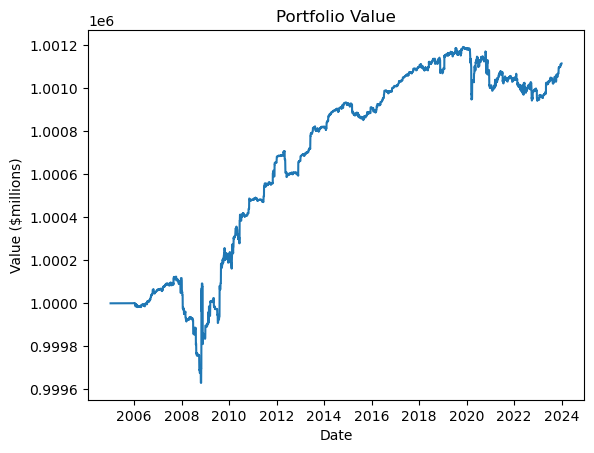

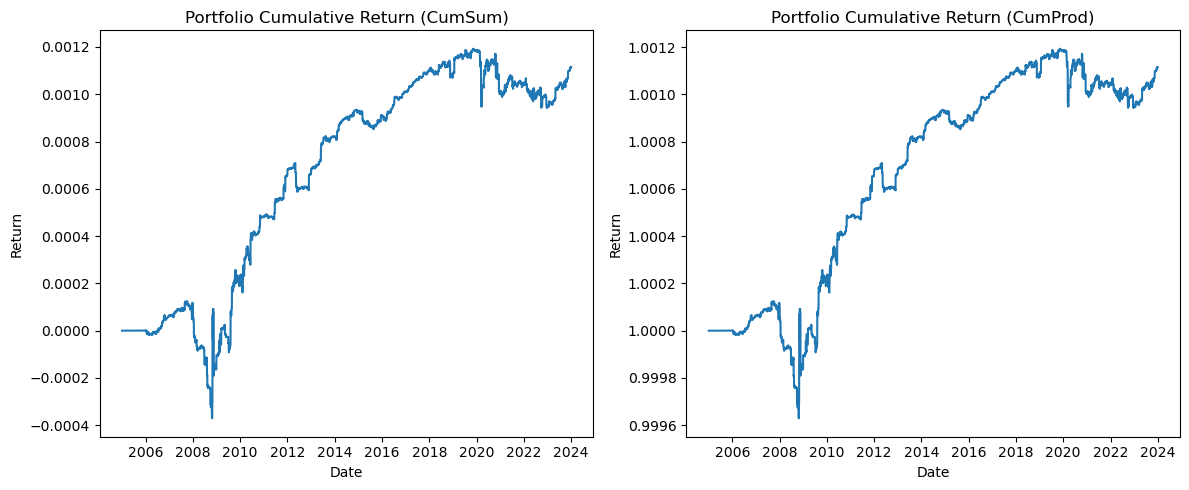

In [12]:
plot_performance(trade_1)

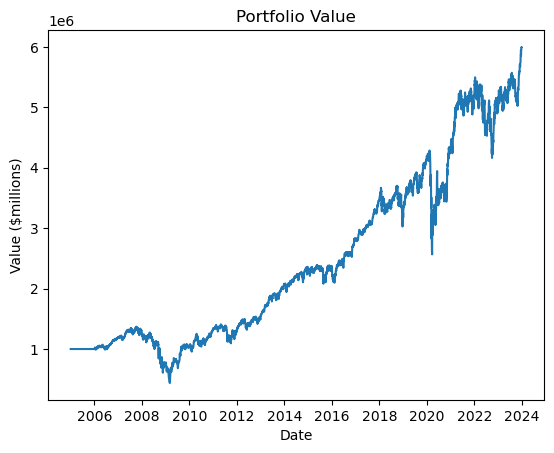

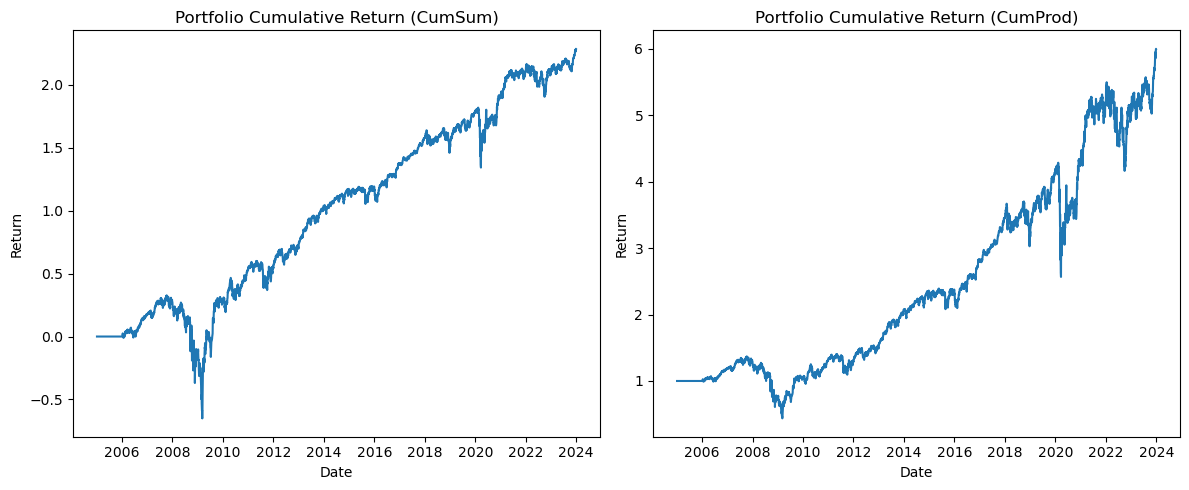

In [31]:
plot_performance(trade_2)

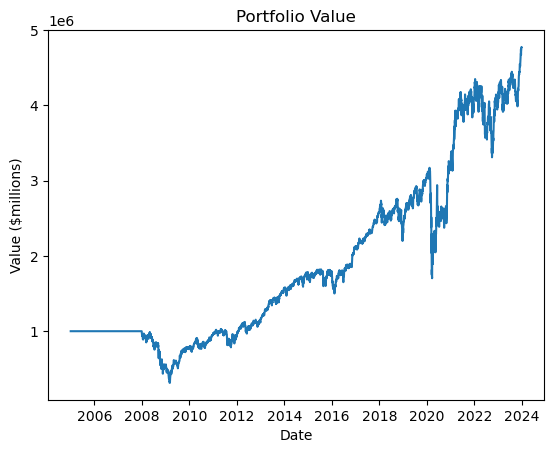

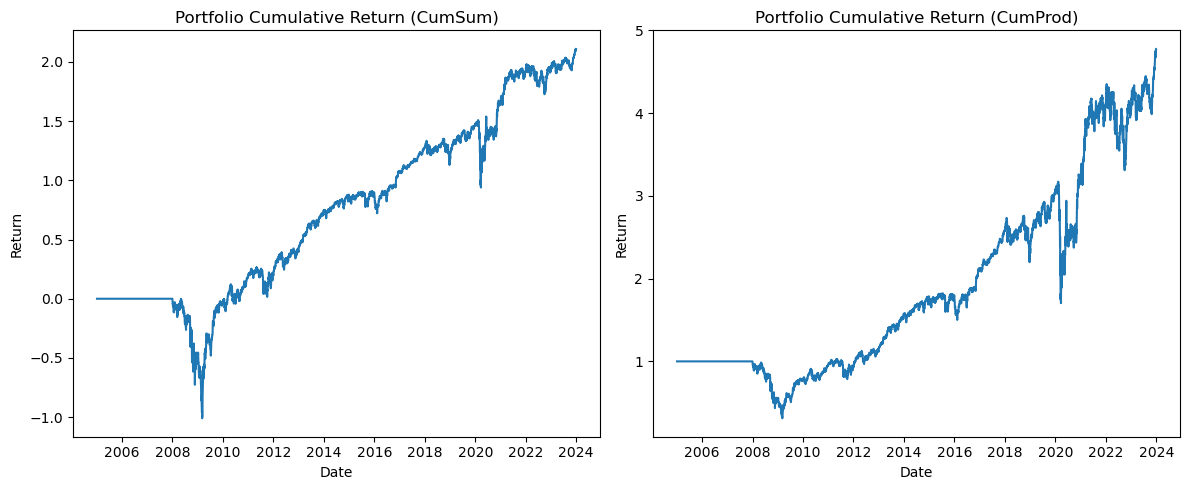

In [32]:
plot_performance(trade_3)

In [33]:
sse_cholesky=pd.read_csv("sse_cholesky.csv")
sse_cholesky.rename(columns={"Unnamed: 0":"date"},inplace=True)
sse_cholesky["date"] = pd.to_datetime(sse_cholesky["date"])
sse_cholesky.set_index("date",inplace=True)

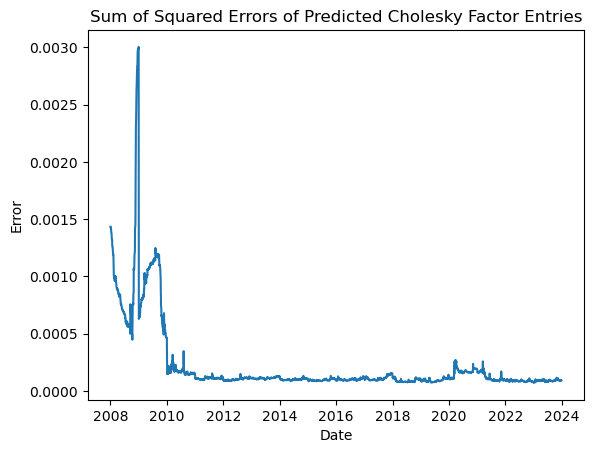

In [38]:
plt.plot(sse_cholesky.index, sse_cholesky['sse_cholesky'])
plt.title('Sum of Squared Errors of Predicted Cholesky Factor Entries')
plt.xlabel('Date')
plt.ylabel('Error')
plt.show()